In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

kaggle.com https://skr.sh/sHCtRlJ7OMl

    

# Загружаем исходные данные

In [2]:
train = np.loadtxt('./train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]


In [4]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

# Визуализируем исходные данные

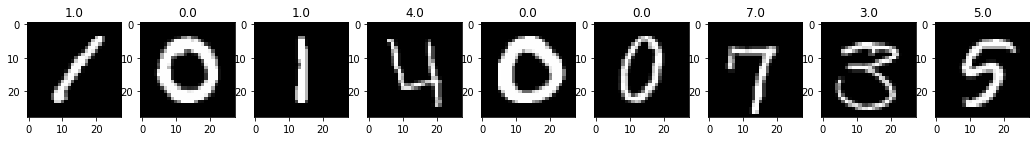

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:9], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=13)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=13)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=13)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=13)

# Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

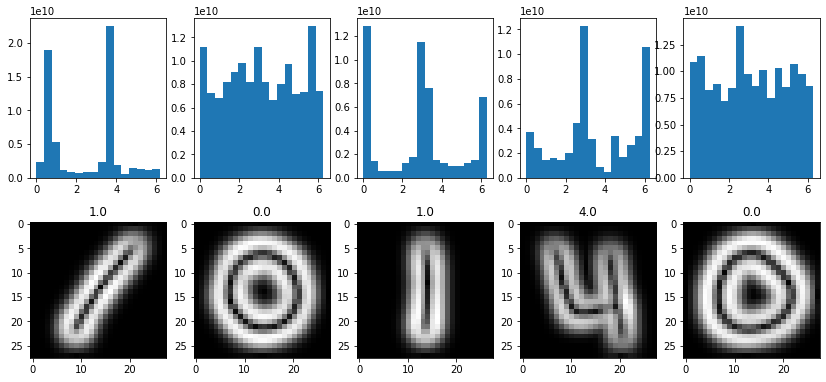

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

# Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

# Нормируем вектор гистограммы

In [14]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [15]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

# Разбиваем выборку на обучение и валидацию

In [97]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.15,
    random_state=42)

In [17]:
from sklearn.svm import SVC

In [98]:
SVC_model = SVC(gamma='scale', C=1.0, decision_function_shape='ovr', degree=7, kernel='poly')

In [99]:
SVC_model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=7, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [100]:
x = SVC_model.predict(x_val)

In [121]:
from sklearn.metrics import accuracy_score
print(accuracy_score(x, y_val))

0.7668253968253969


In [103]:
from sklearn.metrics import classification_report
print(classification_report(x, y_val))

              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66       698
         1.0       0.97      0.97      0.97       680
         2.0       0.79      0.74      0.76       691
         3.0       0.71      0.69      0.70       730
         4.0       0.75      0.75      0.75       627
         5.0       0.70      0.67      0.68       537
         6.0       0.76      0.83      0.79       547
         7.0       0.85      0.88      0.87       640
         8.0       0.65      0.73      0.69       550
         9.0       0.76      0.79      0.77       600

    accuracy                           0.77      6300
   macro avg       0.76      0.77      0.76      6300
weighted avg       0.77      0.77      0.77      6300



In [ ]:
k = SVC_model.predict(test_hist)

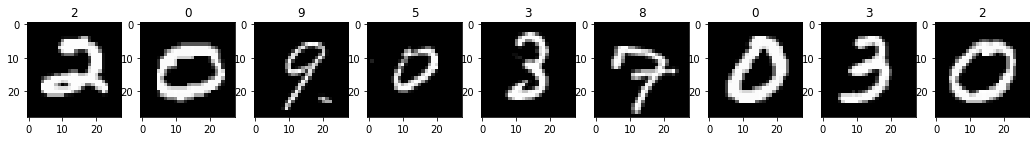

In [138]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:9], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % int(k[i - 1]));

In [77]:
import csv

In [136]:
with open("submit.csv", mode="w", newline='', encoding='utf-8') as dst: 
    writer = csv.DictWriter(dst, fieldnames=['ImageId','Label'])
    writer.writeheader()
    for i, p in enumerate(k, 1):
        writer.writerow({'ImageId': i,'Label': int(p)})
                                   
    